In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [2]:
equipments={}
for no in ['A','B','C','D']:
    equipments[no] = pd.read_csv("dataset/equipment_" + no + ".csv")

In [3]:
import datetime

In [4]:
from tqdm import tqdm

In [7]:
import pandas_profiling as pdp

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_

In [8]:
from sklearn import svm

In [5]:
import random

In [6]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [7]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

In [8]:
def get_slope(day, koutei):
    if len(day) == 0:
        print('!!!!!   no data... why?   !!!!!\n*10')
        return 100
    X = day
    X = [[x] for x in X]
    y = koutei

    clf.fit(X, y)
    slope = clf.coef_[0]

    return slope

In [9]:
def get_sigma(day, koutei):
    if len(day) == 0:
        print('!!!!!   no data... why?   !!!!!\n*10')
        return 100
    X = day
    X = [[x] for x in X]
    y = koutei

    clf.fit(X, y)
    sigma = np.std(clf.predict(X) - y)

    return sigma

In [10]:
def remove_outliers(df):
    median = np.median(df['高低左'])
    tmp = df.loc[abs(df['高低左'] - median) < 0.5]
    
    if len(tmp) == 0:
        print('!!!   len(data) == 0 after remove_outliers   !!!')
        print(no, kilo)
        tmp = df

    return tmp

In [12]:
for no in ['A','B','C','D']:
    print(len(tracks[no]))

10185690
7815753
20324660
5601687


In [13]:
for no in ['A','B','C','D']:
    print(len(tracks[no]['キロ程'].unique()))

27906
21531
55684
15691


In [11]:
tracks['A'].head()

,date,キロ程,高低左,高低右,通り左,通り右,水準,軌間,速度
0,2017-04-01,10000,-1.16,-0.23,1.20,1.20,0.83,3.89,84.0
1,2017-04-01,10001,-1.17,-0.30,1.88,1.88,0.67,4.63,84.0
2,2017-04-01,10002,-1.09,-0.19,2.30,2.30,0.50,5.33,84.0
3,2017-04-01,10003,-0.64,0.20,2.28,2.28,0.46,5.90,84.0
4,2017-04-01,10004,0.47,0.89,1.74,1.74,0.62,6.38,84.5


In [14]:
summarys = {}
for no in ['A','B','C','D']:
    summarys[no] = pd.DataFrame()

In [50]:
%%timeit
random.seed(0)

for no in tqdm(['A','B','C','D']):
    track = tracks[no]
    equipment = equipments[no]
    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)

    '''
    kilos = random.sample(list(track['キロ程'].unique()), 100)
    track = track[track['キロ程'].isin(kilos)]
    equipment = equipment[equipment['キロ程'].isin(kilos)]
    equipment = equipment.reset_index(drop=True)
    '''
    kilos = track['キロ程'].unique()
##    kilos = kilos[track.groupby('キロ程').count()['高低左'].values > 1]
#    tmp = kilos[track.groupby('キロ程').count()['高低左'].values > 200]
#    tmp = track.groupby('キロ程').count()['高低左'].values > 200
#    kilos = kilos[tmp]
#    kilos = kilos[::-1]

    kilos = kilos[:10]#
    track = track[track['キロ程'].isin(kilos)]#
    track = track.reset_index(drop=True)#
    equipment = equipment[equipment['キロ程'].isin(kilos)]#
    equipment = equipment.reset_index(drop=True)#

    days = [get_day(track.loc[track['キロ程'] == kilo, 'date']) for kilo in kilos]
    kouteis = [track.loc[track['キロ程'] == kilo, '高低左'].values for kilo in kilos]
    last_medians = [np.median(kouteis[i][-30:]) for i in range(len(kilos))]
    sigmas = [get_sigma(days[i], kouteis[i]) for i in range(len(kilos))]
    sokuteis = [len(days[i]) for i in range(len(kilos))]
    num_datas = [len(remove_outliers(track.loc[track['キロ程'] == kilo])) for kilo in kilos]
    slopes = [get_slope(get_day(remove_outliers(track.loc[track['キロ程'] == kilo])['date']),
                       remove_outliers(track.loc[track['キロ程'] == kilo])['高低左'].values) for kilo in kilos]

    summary = pd.DataFrame()
    summary['キロ程'] = kilos
    summary['切片'] = last_medians
    summary['傾き'] = slopes
    summary['標準偏差'] = sigmas
    summary['測定回数'] = sokuteis
    summary['データ数'] = num_datas

    summarys[no] = summary

100%|██████████| 4/4 [00:07<00:00,  1.79s/it]

8.61 s ± 1.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
summarys['A']

,キロ程,切片,傾き,標準偏差,測定回数,データ数
0,10000,0.090,-0.001762,2.071749,261,134
1,10001,1.945,-0.001747,2.128162,260,147
2,10002,4.405,-0.001319,3.225023,259,134
3,10003,5.670,-0.000465,3.809769,259,104
4,10004,4.905,-0.000272,3.300315,261,94
5,10005,1.820,0.000215,2.153289,261,103
6,10006,-2.775,0.000391,2.279492,257,74
7,10007,-6.910,0.000966,3.375490,255,120
8,10008,-8.585,0.001604,3.678680,251,118
9,10009,-7.070,0.000959,2.742775,251,125


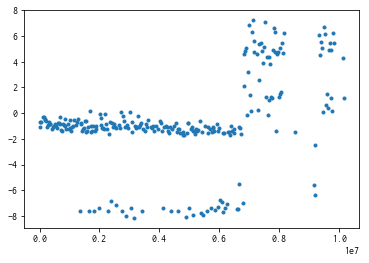

In [44]:
plt.plot(tracks['A'][tracks['A']['キロ程'] == 10002]['高低左'], marker='.', linewidth=0)

In [399]:
rand_summarys.to_csv('summary.csv')

In [444]:
rand_summarys = pd.read_csv('summary.csv', index_col=0)

In [400]:
pdp.ProfileReport(rand_summarys)

Number of variables,15
Number of observations,119484
Total Missing (%),0.0%
Total size in memory,13.7 MiB
Average record size in memory,120.0 B
Numeric,9
Categorical,1
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [445]:
rand_summarys.loc[rand_summarys['傾き'] < rand_summarys['傾き'].quantile(0.05), '傾き'] = np.median(rand_summarys['傾き'])
rand_summarys.loc[rand_summarys['傾き'] > rand_summarys['傾き'].quantile(0.95), '傾き'] = np.median(rand_summarys['傾き'])

In [446]:
rand_summarys.loc[rand_summarys['切片'] < rand_summarys['切片'].quantile(0.05), '切片'] = np.median(rand_summarys['切片'])
rand_summarys.loc[rand_summarys['切片'] > rand_summarys['切片'].quantile(0.95), '切片'] = np.median(rand_summarys['切片'])

In [429]:
len(rand_summarys.loc[rand_summarys['データ数'] == 2])

212

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


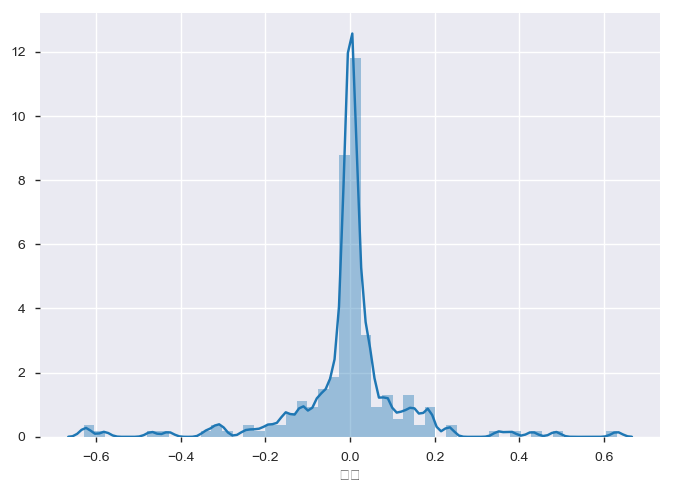

In [409]:
sns.distplot(rand_summarys.loc[rand_summarys['データ数'] == 2, '傾き'])

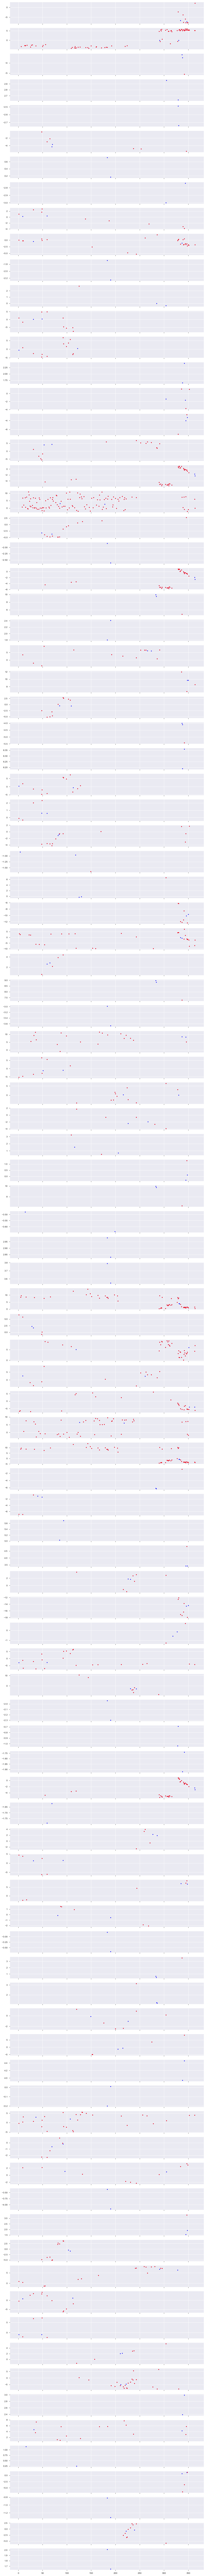

In [428]:
#fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True, sharey=True)
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

rosens = rand_summarys.loc[rand_summarys['データ数'] == 2, '路線']
kilos = rand_summarys.loc[rand_summarys['データ数'] == 2, 'キロ程']
for i, (rosen, kilo) in enumerate(random.sample(list(zip(rosens, kilos)), 100)):
    track = tracks[rosen]
    data = track[track['キロ程'] == kilo]
    data = data.dropna(subset = ['高低左'])
    data = data.reset_index(drop=True)
    data = flag_outliers(data)
    data['days'] = get_day(data['date'])
    axes[i].plot(data['days'], data['高低左'], marker='.', linewidth=0, c='b')
    axes[i].plot(data.loc[data['flag'] == 1, ['days']], data.loc[data['flag'] == 1, ['高低左']], marker='.', linewidth=0, c='r')

In [430]:
len(rand_summarys.loc[rand_summarys['データ数'] == 3])

150

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


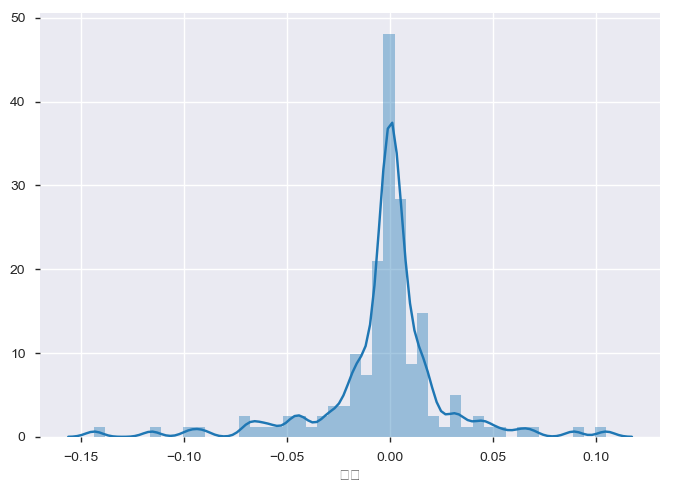

In [431]:
sns.distplot(rand_summarys.loc[rand_summarys['データ数'] == 3, '傾き'])

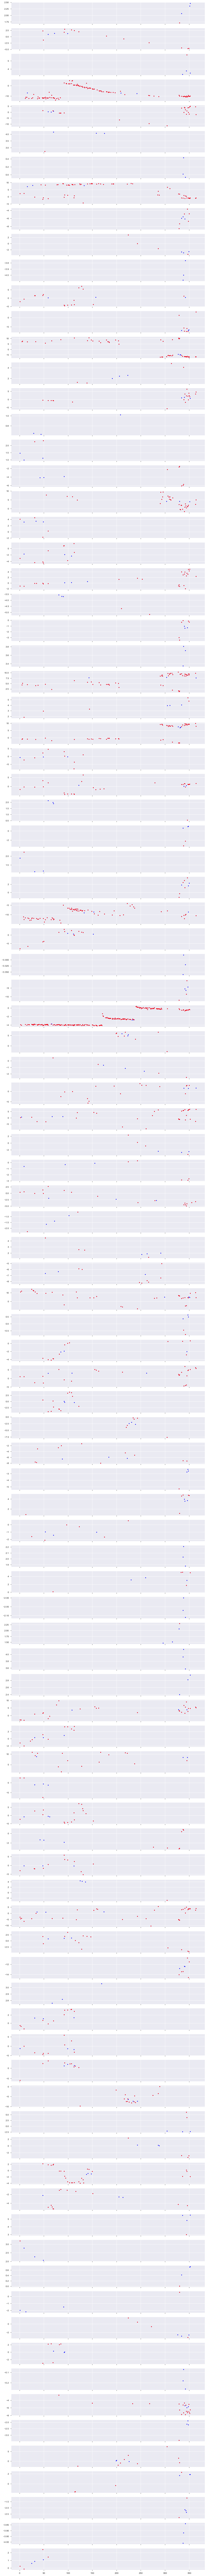

In [432]:
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

rosens = rand_summarys.loc[rand_summarys['データ数'] == 3, '路線']
kilos = rand_summarys.loc[rand_summarys['データ数'] == 3, 'キロ程']
for i, (rosen, kilo) in enumerate(random.sample(list(zip(rosens, kilos)), 100)):
    track = tracks[rosen]
    data = track[track['キロ程'] == kilo]
    data = data.dropna(subset = ['高低左'])
    data = data.reset_index(drop=True)
    data = flag_outliers(data)
    data['days'] = get_day(data['date'])
    axes[i].plot(data['days'], data['高低左'], marker='.', linewidth=0, c='b')
    axes[i].plot(data.loc[data['flag'] == 1, ['days']], data.loc[data['flag'] == 1, ['高低左']], marker='.', linewidth=0, c='r')

In [433]:
len(rand_summarys.loc[rand_summarys['データ数'] == 10])

81

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


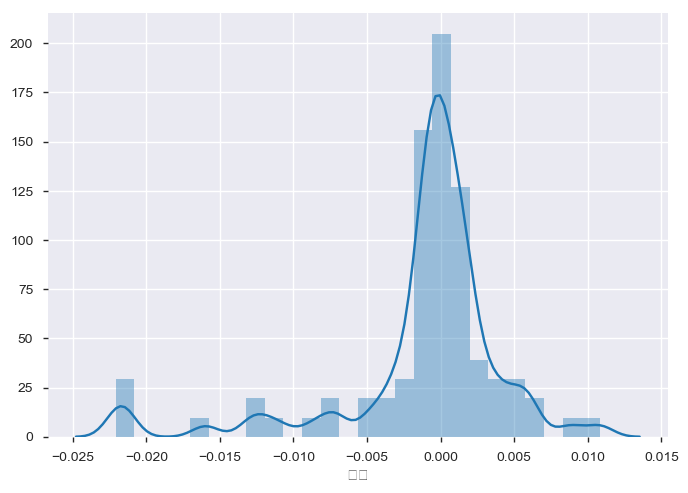

In [434]:
sns.distplot(rand_summarys.loc[rand_summarys['データ数'] == 10, '傾き'])

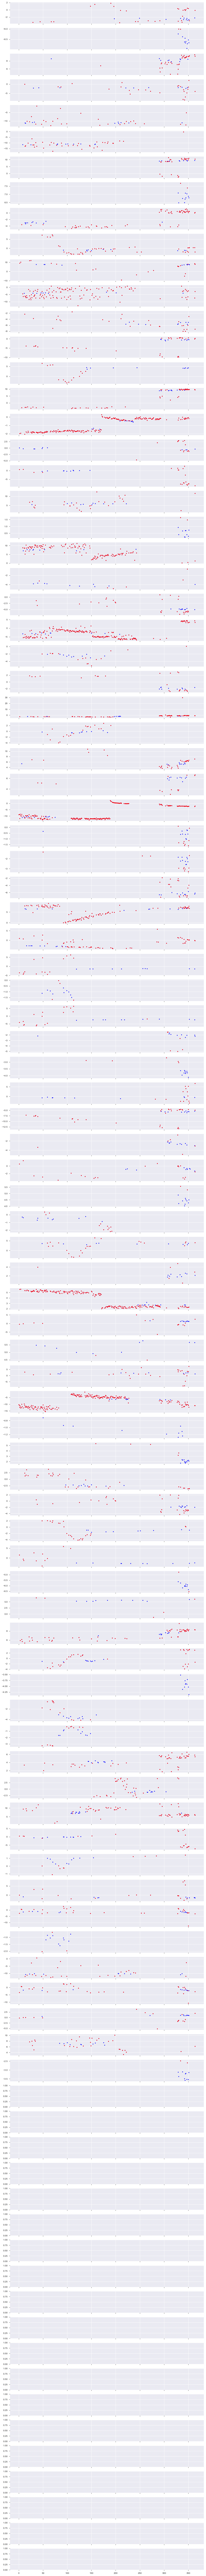

In [437]:
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

rosens = rand_summarys.loc[rand_summarys['データ数'] == 10, '路線']
kilos = rand_summarys.loc[rand_summarys['データ数'] == 10, 'キロ程']
for i, (rosen, kilo) in enumerate(random.sample(list(zip(rosens, kilos)), min(100, len(kilos)))):
    track = tracks[rosen]
    data = track[track['キロ程'] == kilo]
    data = data.dropna(subset = ['高低左'])
    data = data.reset_index(drop=True)
    data = flag_outliers(data)
    data['days'] = get_day(data['date'])
    axes[i].plot(data['days'], data['高低左'], marker='.', linewidth=0, c='b')
    axes[i].plot(data.loc[data['flag'] == 1, ['days']], data.loc[data['flag'] == 1, ['高低左']], marker='.', linewidth=0, c='r')

In [447]:
pdp.ProfileReport(rand_summarys)

Number of variables,15
Number of observations,119484
Total Missing (%),0.0%
Total size in memory,14.6 MiB
Average record size in memory,128.0 B
Numeric,9
Categorical,1
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [449]:
index_master = pd.read_csv('dataset/index_master.csv', index_col=0)

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [450]:
index_master

,路線,date,キロ程
id,,,
0,A,2018-04-01,10000
1,A,2018-04-01,10001
2,A,2018-04-01,10002
3,A,2018-04-01,10003
4,A,2018-04-01,10004
5,A,2018-04-01,10005
6,A,2018-04-01,10006
7,A,2018-04-01,10007
8,A,2018-04-01,10008


In [471]:
#rand_summarysをキロ程の逆順で作っちゃったから、昇順に治す
summarys = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = rand_summarys[rand_summarys['路線'] == no]
    tmp = track.sort_values('キロ程')
    summarys = pd.concat([summarys, tmp], axis=0)

In [472]:
summarys

,路線,キロ程,傾き,切片,標準偏差,測定回数,データ数,バラスト,ロングレール,マクラギ種別,橋りょう,踏切,通トン,曲線半径,フラグ
27611,A,10000,-0.001762,0.090,2.071749,261,134,1,0,1,0,0,8.073,1000,0
27610,A,10001,-0.001747,1.945,2.128162,260,147,1,0,1,0,0,8.073,1000,0
27609,A,10002,-0.001319,0.020,3.225023,259,134,1,0,2,0,0,8.073,1000,0
27608,A,10003,-0.000465,0.020,3.809769,259,104,1,0,1,0,0,8.073,1000,0
27607,A,10004,-0.000272,0.020,3.300315,261,94,1,0,1,0,0,8.073,1000,0
27606,A,10005,0.000215,1.820,2.153289,261,103,1,0,1,0,0,8.073,1000,0
27605,A,10006,0.000391,-2.775,2.279492,257,74,1,0,1,0,0,8.073,1000,0
27604,A,10007,0.000966,0.020,3.375490,255,120,1,0,1,0,0,8.073,1000,0
27603,A,10008,0.001604,0.020,3.678680,251,118,1,0,1,0,0,8.073,1000,0
27602,A,10009,0.000959,0.020,2.742775,251,125,1,0,1,0,0,8.073,1000,0


In [527]:
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[summarys['路線'] == no]

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no
    sub.index = track['キロ程'].unique() #I did a good job!

    sub.loc[summary['キロ程'], '傾き'] = summary['傾き']
    sub.loc[summary['キロ程'], '切片'] = summary['切片']
    sub = sub.reset_index(drop=True)

    submit = pd.concat([submit, sub], axis=0)
    submit = submit.reset_index(drop=True)

In [528]:
submit

,キロ程,路線,傾き,切片
0,10000,A,-0.000740,-0.780
1,10001,A,-0.000375,-0.740
2,10002,A,-0.000387,-0.340
3,10003,A,-0.000450,0.515
4,10004,A,0.000053,1.030
5,10005,A,0.000136,1.230
6,10006,A,0.000475,1.040
7,10007,A,0.000396,0.560
8,10008,A,0.000174,0.125
9,10009,A,0.000066,-0.325


In [529]:
submit.loc[submit['傾き'].isnull(), '傾き'] = np.median(submit.loc[submit['傾き'].notnull(), '傾き'])
submit.loc[submit['切片'].isnull(), '切片'] = np.median(submit.loc[submit['切片'].notnull(), '切片'])

In [530]:
submit

,キロ程,路線,傾き,切片
0,10000,A,-0.000740,-0.780
1,10001,A,-0.000375,-0.740
2,10002,A,-0.000387,-0.340
3,10003,A,-0.000450,0.515
4,10004,A,0.000053,1.030
5,10005,A,0.000136,1.230
6,10006,A,0.000475,1.040
7,10007,A,0.000396,0.560
8,10008,A,0.000174,0.125
9,10009,A,0.000066,-0.325


In [ ]:
'''
p = []
for no, track in tracks.items():
    mean_by_kiros = track.groupby("キロ程").mean()["高低左"] #キロ程毎の平均値
    mean_by_kiros91 = np.array(list(mean_by_kiros.values) * 91) # 評価期間の91日分に拡張
    p.extend(mean_by_kiros91) # 配列に追加

submit = pd.DataFrame(p)
submit = submit.fillna(0) #欠損値は0で補完
submit =submit.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし
submit.to_csv("submit.csv", header=None)
'''

In [531]:
p = []
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    p.extend([a + b*i for a, b in zip(tmp['切片'], tmp['傾き']) for i in range(91)])

submision = pd.DataFrame(p)
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし
submision.to_csv("submit.csv", header=None)

In [532]:
submision

,0
0,-0.78
1,-0.78
2,-0.78
3,-0.78
4,-0.78
5,-0.78
6,-0.78
7,-0.79
8,-0.79
9,-0.79
